In [238]:
%load_ext autoreload
%autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from tools import make_track, make_ER, kalman_filter, ols_regression, lasso_regression, ridge_regression
from hc_graph import hc_stock
sns.set()

In [353]:
prices = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU','BNPIFIT',
                            'BNPIFGE', 'BNPIFFR', 'BNPIFSP']]

prices_all = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]

returns = prices.resample("7D").first().pct_change().dropna()
returns_all = prices_all.resample("7D").first().pct_change().dropna()

In [366]:
sx5e = returns[["BNPIFEU"]]
bch = returns.drop("BNPIFEU", axis=1)
bch_all = returns_all.drop("BNPIFEU", axis=1)

size = 52
freq = 4

df_res = prices.loc[replication.index][["BNPIFEU"]]

In [367]:
df_weight = ols_regression(sx5e, bch, size, freq)
df_weight_all = ols_regression(sx5e, bch_all, size, freq)

prices_for_track = prices.loc[df_weight.index[0]:].drop("BNPIFEU", axis=1)
prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("BNPIFEU", axis=1)

replication = make_track(prices_for_track, df_weight)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res["OLS"] = replication
df_res["OLS all"] = replication_all

In [370]:
df_weight_ridge = ridge_regression(sx5e, bch, size, freq, l=4e-3)
df_weight_ridge_all = ridge_regression(sx5e, bch_all, size, freq, l=6e-3)

replication_ridge = make_track(prices_for_track, df_weight_ridge)
replication_ridge_all = make_track(prices_for_track_all, df_weight_ridge_all)

df_res["Ridge"] = replication_ridge
df_res["Ridge all"] = replication_ridge_all

In [368]:
df_weight_lasso = lasso_regression(sx5e, bch, size, freq, l=1e-4)
df_weight_lasso_all = lasso_regression(sx5e, bch_all, size, freq, l=6e-5)

replication_lasso = make_track(prices_for_track, df_weight_lasso)
replication_lasso_all = make_track(prices_for_track_all, df_weight_lasso_all)

df_res["Lasso"] = replication_lasso
df_res["Lasso all"] = replication_lasso_all

In [369]:
df_weight_kalman = kalman_filter(sx5e, bch, freq, sigma_weight=0.05, sigma_return=0.005)
df_weight_kalman_all = kalman_filter(sx5e, bch_all, freq, sigma_weight=0.05, sigma_return=0.005)

prices_for_track_kalman = prices.loc[df_weight_kalman.index[0]:].drop("BNPIFEU", axis=1)
prices_for_track_all_kalman = prices_all.loc[df_weight_kalman_all.index[0]:].drop("BNPIFEU", axis=1)

replication_kalman = make_track(prices_for_track_kalman, df_weight_kalman).loc[df_weight.index[0]:]
replication_kalman_all = make_track(prices_for_track_all_kalman, df_weight_kalman_all).loc[df_weight.index[0]:]

df_res["Kalman"] = replication_kalman
df_res["Kalman all"] = replication_kalman_all

In [371]:
df_res = df_res / df_res.iloc[0]

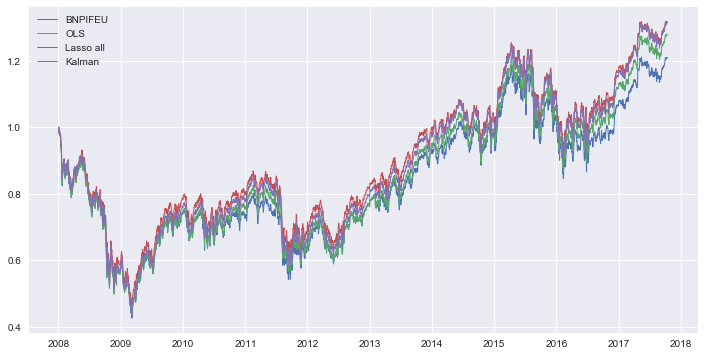

In [372]:
df_res[['BNPIFEU', 'OLS', 'Lasso all', 'Kalman']].plot(figsize=(12,6),linewidth=1)

In [373]:
g = hc_stock(df_res)
g.plot()

In [374]:
df_res.pct_change().corr(method="pearson")

,BNPIFEU,OLS,OLS all,Lasso,Lasso all,Kalman,Kalman all,Ridge,Ridge all
BNPIFEU,1.000000,0.987042,0.934428,0.986138,0.986021,0.987056,0.981599,0.977620,0.974914
OLS,0.987042,1.000000,0.948639,0.999288,0.998935,0.999295,0.992355,0.989674,0.984926
OLS all,0.934428,0.948639,1.000000,0.949106,0.951125,0.946233,0.946198,0.939330,0.943055
Lasso,0.986138,0.999288,0.949106,1.000000,0.998972,0.998578,0.991544,0.992267,0.985115
Lasso all,0.986021,0.998935,0.951125,0.998972,1.000000,0.998262,0.993108,0.990156,0.986872
Kalman,0.987056,0.999295,0.946233,0.998578,0.998262,1.000000,0.993611,0.990850,0.985785
Kalman all,0.981599,0.992355,0.946198,0.991544,0.993108,0.993611,1.000000,0.984686,0.989120
Ridge,0.977620,0.989674,0.939330,0.992267,0.990156,0.990850,0.984686,1.000000,0.982702
Ridge all,0.974914,0.984926,0.943055,0.985115,0.986872,0.985785,0.989120,0.982702,1.000000


In [362]:
returns_track = df_res.pct_change().dropna()
feu = returns_track['BNPIFEU']
returns_track = returns_track.drop('BNPIFEU', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df

,Tracking error
OLS,0.002551
OLS all,0.005581
Ridge,0.005607
Ridge all,0.003479
Lasso,0.002798
Lasso all,0.002711
Kalman,0.002731
Kalman all,0.002911


In [363]:
returns_track = df_res.pct_change().dropna()
feu = returns_track['BNPIFEU']
returns_track = returns_track.drop('BNPIFEU', axis=1)
df_2 = pd.DataFrame()
df_2['Average error'] = (np.abs(returns_track.T - feu.values)).mean(axis=1)
df_2

,Average error
OLS,0.001561
OLS all,0.003418
Ridge,0.003795
Ridge all,0.002281
Lasso,0.001718
Lasso all,0.001626
Kalman,0.001571
Kalman all,0.001710


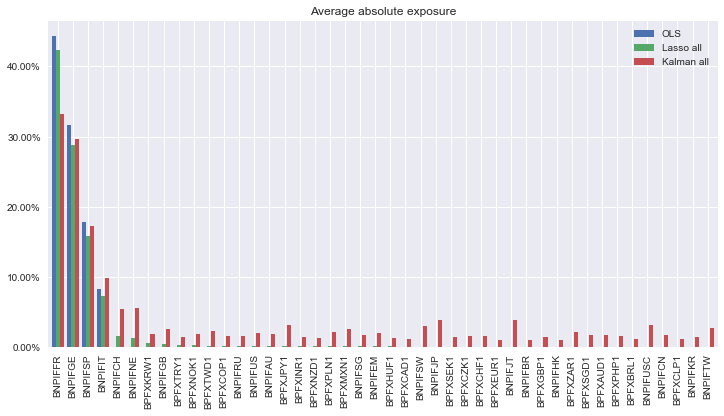

In [375]:
weight = pd.DataFrame(data={'Lasso all': np.abs(df_weight_lasso_all).mean(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', np.abs(df_weight).mean(axis=0))
weight.insert(1, 'OLS all', np.abs(df_weight_all).mean(axis=0))
weight.insert(2, 'Lasso', np.abs(df_weight_lasso).mean(axis=0))
weight['Ridge'] = np.abs(df_weight_ridge).mean(axis=0)
weight['Ridge all'] = np.abs(df_weight_ridge_all).mean(axis=0)
weight['Kalman'] = np.abs(df_weight_kalman).mean(axis=0)
weight['Kalman all'] = np.abs(df_weight_kalman_all).mean(axis=0)
ax = weight[['OLS', 'Lasso all', 'Kalman all']].plot(kind='bar', title='Average absolute exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

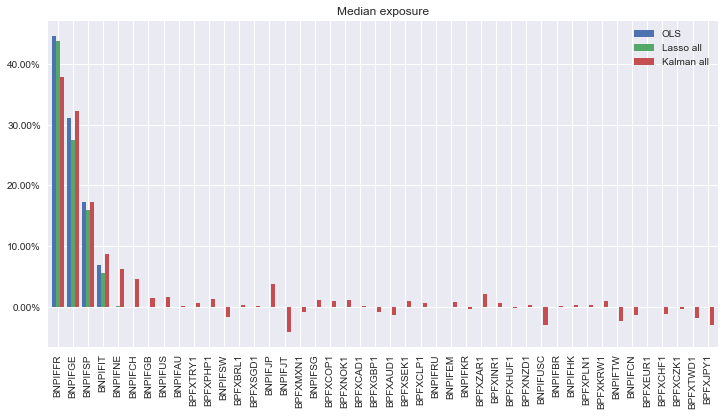

In [376]:
weight = pd.DataFrame(data={'Lasso all': (df_weight_lasso_all).median(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', (df_weight).median(axis=0))
weight.insert(1, 'OLS all', (df_weight_all).median(axis=0))
weight.insert(2, 'Lasso', (df_weight_lasso).median(axis=0))
weight['Ridge'] = (df_weight_ridge).median(axis=0)
weight['Ridge all'] = (df_weight_ridge_all).median(axis=0)
weight['Kalman'] = (df_weight_kalman).median(axis=0)
weight['Kalman all'] = (df_weight_kalman_all).median(axis=0)
ax = weight[['OLS', 'Lasso all', 'Kalman all']].plot(kind='bar', title='Median exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

In [377]:
weight.sum()

OLS           1.001907
OLS all       1.001657
Lasso         0.912065
Lasso all     0.929543
Ridge         0.763843
Ridge all     0.993617
Kalman        0.985152
Kalman all    1.035075
dtype: float64

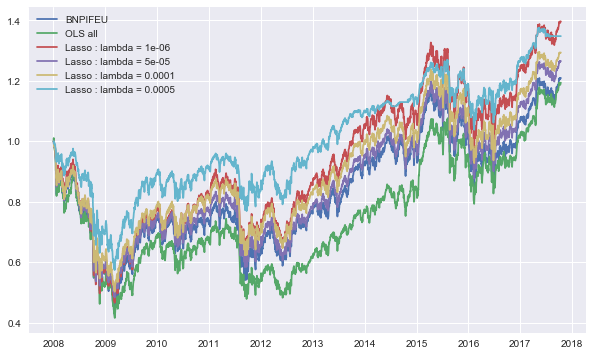

In [380]:
df_l = df_res[['BNPIFEU', 'OLS all']].copy()

for l in [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]:
    weight_lasso = lasso_regression(sx5e, bch_all, size, freq, l=l)
    replication_lasso = make_track(prices_for_track, weight_lasso)
    df_l[('Lasso : lambda = '+str(l))] = replication_lasso

df_l = df_l / df_l.iloc[0]

df_l.plot(figsize=(10, 6))